<a href="https://colab.research.google.com/github/antonsysoev/ktmi_pm/blob/%D0%9F%D0%9C-19/PCA_%2B_FA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Анализ главных компонентов

In [ ]:
install.packages("factoextra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘lazyeval’, ‘later’, ‘carData’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’, ‘estimability’, ‘numDeriv’, ‘mvtnorm’, ‘xtable’, ‘corrplot’, ‘viridis’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘plyr’, ‘Rcpp’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’, ‘ggrepel’




In [ ]:
if(!require(devtools)) install.packages("devtools")
devtools::install_github("kassambara/factoextra")

In [ ]:
library(factoextra)

Данные

In [ ]:
data(decathlon2)
decathlon2.active <- decathlon2[1:23, 1:10]
head(decathlon2.active[, 1:6])

Вычисление главных компонентов

In [ ]:
res.pca <- prcomp(decathlon2.active, scale = TRUE)

In [ ]:
fviz_eig(res.pca)

In [ ]:
fviz_pca_ind(res.pca,
             col.ind = "cos2", # Color by the quality of representation
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

In [ ]:
fviz_pca_var(res.pca,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

In [ ]:
fviz_pca_biplot(res.pca, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969"  # Individuals color
                )

In [ ]:
# Eigenvalues
eig.val <- get_eigenvalue(res.pca)
eig.val
  
# Results for Variables
res.var <- get_pca_var(res.pca)
res.var$coord          # Coordinates
res.var$contrib        # Contributions to the PCs
res.var$cos2           # Quality of representation 
# Results for individuals
res.ind <- get_pca_ind(res.pca)
res.ind$coord          # Coordinates
res.ind$contrib        # Contributions to the PCs
res.ind$cos2           # Quality of representation 

покажем, как предсказать координаты дополнительных индивидуумов и переменных, используя только информацию, предоставленную ранее выполненным PCA.

Данные: строки с 24 по 27 и столбцы с 1 по 10 [в наборах данных decathlon2]. Новые данные должны содержать столбцы (переменные) с теми же именами и в том же порядке, что и активные данные, использованные для расчета PCA.

In [ ]:
# Data for the supplementary individuals
ind.sup <- decathlon2[24:27, 1:10]
ind.sup[, 1:6]

In [ ]:
ind.sup.coord <- predict(res.pca, newdata = ind.sup)
ind.sup.coord[, 1:4]

In [ ]:
# Plot of active individuals
p <- fviz_pca_ind(res.pca, repel = TRUE)
# Add supplementary individuals
fviz_add(p, ind.sup.coord, color ="blue")

Предсказанные координаты особей могут быть рассчитаны вручную следующим образом:

* Центрировать и масштабировать данные новых реализаций, используя  центр и масштаб PCA.
* Вычислить прогнозируемые координаты путем умножения масштабированных значений на собственные векторы (нагрузки) главных компонент.


In [ ]:
# Centering and scaling the supplementary individuals
ind.scaled <- scale(ind.sup, 
                    center = res.pca$center,
                    scale = res.pca$scale)
# Coordinates of the individividuals
coord_func <- function(ind, loadings){
  r <- loadings*ind
  apply(r, 2, sum)
}
pca.loadings <- res.pca$rotation
ind.sup.coord <- t(apply(ind.scaled, 1, coord_func, pca.loadings ))
ind.sup.coord[, 1:4]

Факторный анализ

In [ ]:
install.packages("psych")

In [ ]:
library(psych)
library(corrplot)
library(ggplot2)
library(car)

In [ ]:
url <- "https://raw.githubusercontent.com/housecricket/data/main/efa/sample1.csv"
data_survey <- read.csv(url, sep = ",")

In [ ]:
describe(data_survey)

In [ ]:
dat <- data_survey[ , -1] 
head(dat)

,KM1,KM2,KM3,QC1,QC2,QC3,CT1,CT2,CT3,PC1,PC2,PC3,QD
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5,5,5,5,2,1,1,3,1,4,1,3,4
2,3,3,3,4,5,3,4,5,4,2,2,2,4
3,2,2,2,2,2,1,3,3,3,4,3,5,2
4,4,3,3,4,3,4,4,4,4,1,1,3,3
5,4,4,4,2,3,4,4,4,4,3,3,5,4
6,1,1,1,2,5,3,5,5,5,4,3,5,3


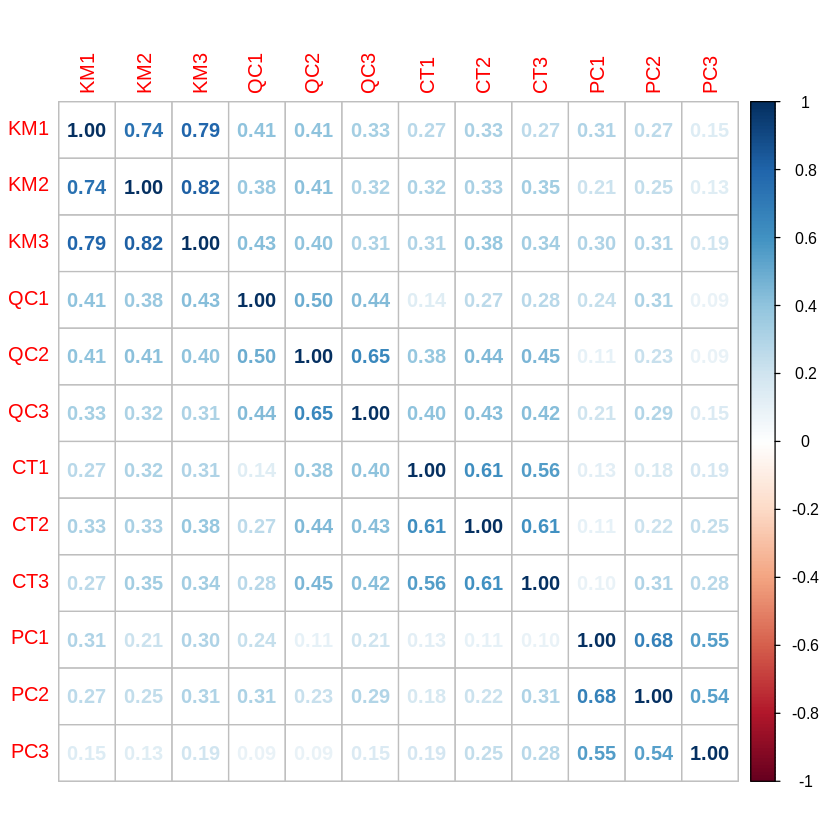

In [ ]:
datamatrix <- cor(dat[,c(-13)])
corrplot(datamatrix, method="number")

In [ ]:
X <- dat[,-c(13)]
Y <- dat[,13]

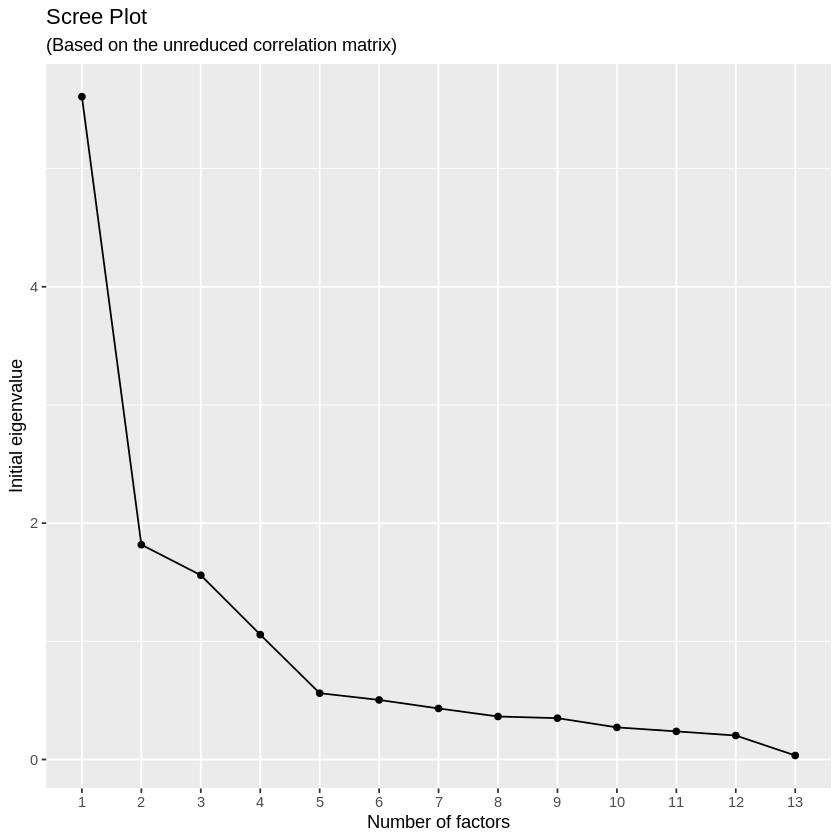

In [ ]:
fafitfree <- fa(dat,nfactors = ncol(X), rotate = "none")
n_factors <- length(fafitfree$e.values)
scree     <- data.frame(
  Factor_n =  as.factor(1:n_factors), 
  Eigenvalue = fafitfree$e.values)
ggplot(scree, aes(x = Factor_n, y = Eigenvalue, group = 1)) + 
  geom_point() + geom_line() +
  xlab("Number of factors") +
  ylab("Initial eigenvalue") +
  labs( title = "Scree Plot", 
        subtitle = "(Based on the unreduced correlation matrix)")

In [ ]:
parallel <- fa.parallel(X)

In [ ]:
fa.none <- fa(r=X, 
 nfactors = 4, 
 # covar = FALSE, SMC = TRUE,
 fm="pa", # type of factor analysis we want to use (“pa” is principal axis factoring)
 max.iter=100, # (50 is the default, but we have changed it to 100
 rotate="varimax") # none rotation
print(fa.none)

In [ ]:
fa.diagram(fa.none)